In [16]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import osmnx as ox
from functools import partial
import numpy as np
import pandas as pd
from multiprocessing import Pool,cpu_count
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import MultiLineString,MultiPoint,Point,LineString,MultiPolygon
from shapely import wkt
from shapely.ops import nearest_points
import glob
import time
import gpxpy
from itertools import groupby
import random
import sklearn
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import savgol_filter
from lib_garmin_elevation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.04562878608703613


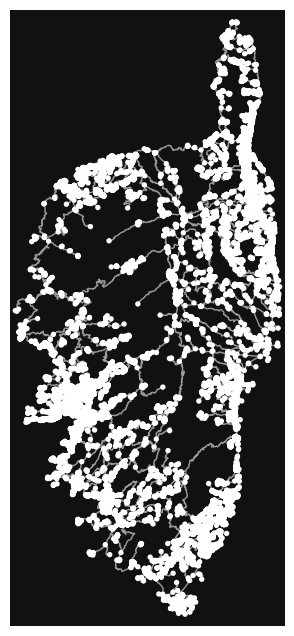

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
place_name='Corse, France'
G_dir=ox.graph_from_place(place_name,network_type='drive')
G_dir=to_multi_graph(G_dir)
crs=ox.graph_to_gdfs(G_dir,edges=False).estimate_utm_crs()
G_proj=ox.project_graph(G_dir,to_crs=crs)
t1=time.time()
add_missing_geometries(G_proj)
t2=time.time()
print(t2-t1)

ox.plot_graph(G_proj)


In [3]:
def parallelized_preprocess(file_paths):
    garmin_dfs=[preprocess(file_path,G_proj,crs=crs) for file_path in file_paths]
    return pd.concat(garmin_dfs)

In [4]:
GENERATE=True
garmin_df_path='/home/pierre/Documents/garmin_df.csv'
if GENERATE:
    t1=time.time()
    nb_cpu=cpu_count()-1
    file_paths=glob.glob('/home/pierre/Documents/garmin_corse/*.gpx')
    chunked_file_paths=chunk(file_paths,nb_cpu)
    with Pool(nb_cpu) as p:
        garmin_dfs=p.map(parallelized_preprocess,chunked_file_paths)
    garmin_df=pd.concat(garmin_dfs)
    garmin_df=garmin_df.to_crs('epsg:4326')
    garmin_df.to_csv(garmin_df_path,index=False)
    garmin_df=garmin_df.to_crs(crs)
    t2=time.time()
    print(t2-t1)
else:
    garmin_df=pd.read_csv(garmin_df_path)
    garmin_df['geometry']=garmin_df['geometry'].apply(wkt.loads)
    garmin_df=gpd.GeoDataFrame(garmin_df,geometry='geometry',crs='epsg:4326')
    garmin_df['time']=pd.to_datetime(garmin_df['time'])
    garmin_df['edge']=garmin_df['edge'].apply(eval)
    garmin_df=garmin_df.to_crs(crs)
garmin_df

reading file took 0.881061 s
estimating crs took 0.018678 s
reading file took 1.440510 s
reading file took 1.457016 sreading file took 1.458492 s

estimating crs took 0.021962 s
estimating crs took 0.015427 s
estimating crs took 0.024750 s
reading file took 2.581102 s
projecting took  1.134759 s
estimating crs took 0.035865 s
reading file took 2.803326 s
estimating crs took 0.032724 s
reading file took 2.891294 s
estimating crs took 0.032012 s
projecting took  2.137387 s
adding segments took 0.511401 s
projecting took  1.689000 s
adding segments took 0.199945 s
adding segments took 0.372331 s
projecting took  2.062945 s
reading file took 0.104971 s
estimating crs took 0.013080 s
adding segments took 0.218645 s
reading file took 0.846048 s
reading file took 0.325732 s
estimating crs took 0.015667 s

estimating crs took 0.014219 sprojecting took  0.527505 s
adding segments took 0.200110 s
reading file took 0.781183 s
estimating crs took 0.015873 s
projecting took  1.686039 s
projecting t

,file_path,geometry,elevation,time,edge,distance_ls,pre_segment,orientation,segment
0,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482452.154 4710449.517),8.200000,2023-09-05 13:57:31+00:00,"(51319395, 9064150112, 0)",406.639341,0,1.0,0
1,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482455.064 4710445.288),30.200001,2023-09-05 13:57:32+00:00,"(51319395, 9064150112, 0)",411.773043,0,1.0,0
2,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482458.498 4710440.297),32.400002,2023-09-05 13:57:33+00:00,"(51319395, 9064150112, 0)",417.831396,0,1.0,0
3,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482461.864 4710435.404),33.000000,2023-09-05 13:57:34+00:00,"(51319395, 9064150112, 0)",423.769641,0,1.0,0
4,/home/pierre/Documents/garmin_corse/activity_1...,POINT (482464.925 4710430.956),33.400002,2023-09-05 13:57:35+00:00,"(51319395, 9064150112, 0)",429.169124,0,1.0,0
...,...,...,...,...,...,...,...,...,...
14392,/home/pierre/Documents/garmin_corse/albin_2.gpx,POINT (482312.549 4710652.407),69.000000,2021-04-01 14:31:34+00:00,"(51319395, 9064150112, 0)",160.359109,44,-1.0,83
14393,/home/pierre/Documents/garmin_corse/albin_2.gpx,POINT (482311.203 4710654.365),70.000000,2021-04-01 14:31:35+00:00,"(51319395, 9064150112, 0)",157.983103,44,-1.0,83
14394,/home/pierre/Documents/garmin_corse/albin_2.gpx,POINT (482310.766 4710655.000),70.000000,2021-04-01 14:31:36+00:00,"(51319395, 9064150112, 0)",157.212514,44,-1.0,83
14395,/home/pierre/Documents/garmin_corse/albin_2.gpx,POINT (482311.316 4710654.200),70.000000,2021-04-01 14:31:37+00:00,"(51319395, 9064150112, 0)",158.183261,44,1.0,84


In [17]:
plt.rcParams['figure.figsize']=(20,20)
t1=time.time()
GG=build_multidigraph(G_proj,garmin_df)
GG_un=nx.Graph(GG)
t2=time.time()
print(t2-t1)

6.6249144077301025


In [18]:
edges=sorted(garmin_df['edge'].unique(),key=lambda edge:G_proj.get_edge_data(*edge)['length'])
edges

[(1828637782, 1828637786, 0),
 (339375366, 339375369, 0),
 (8130643497, 8130643456, 0),
 (6234664018, 59744638, 0),
 (7727221576, 7727221575, 0),
 (500865542, 3744637226, 0),
 (10600235545, 486578464, 0),
 (6717820506, 6717820563, 0),
 (8130643482, 8130643490, 0),
 (8130643459, 8130643460, 0),
 (1038364561, 5357133108, 0),
 (6717820545, 6717820548, 0),
 (10600235549, 486578425, 0),
 (6141266973, 6141266977, 0),
 (91584373, 560111664, 0),
 (486536505, 9081243617, 0),
 (82577174, 1305604117, 0),
 (59744616, 1363937015, 0),
 (344189020, 10758881318, 0),
 (559124471, 559124462, 0),
 (386950447, 256004649, 0),
 (14472100, 9074944632, 0),
 (759546354, 759546425, 0),
 (4789410635, 4789410636, 0),
 (1038364561, 7737506285, 0),
 (1819179800, 9081244936, 0),
 (500865546, 10119961737, 0),
 (2218352145, 7921675181, 0),
 (60676937, 10600240028, 0),
 (7744445119, 10049655816, 0),
 (5604490183, 9803927147, 0),
 (60613179, 60613180, 0),
 (1305604117, 4413927946, 0),
 (394580561, 7746110083, 0),
 (3931

0.0002205371856689453


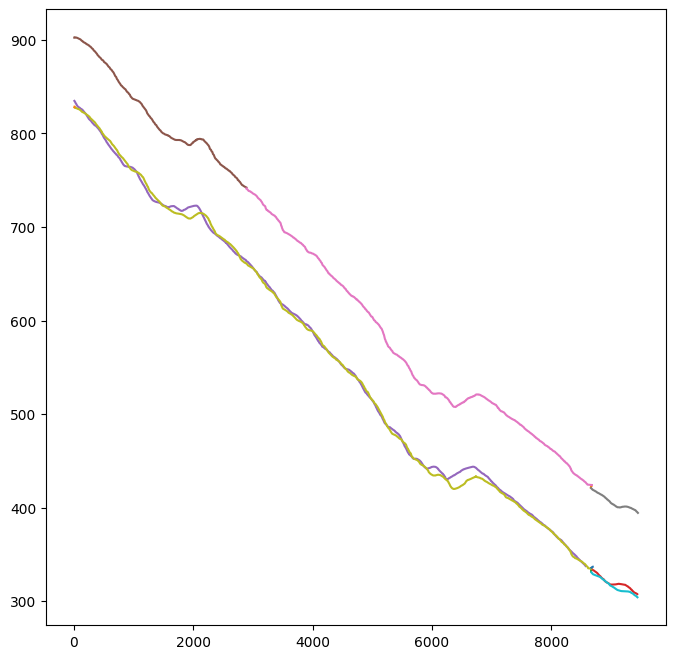

In [19]:
plt.rcParams['figure.figsize']=(8,8)
edge=(301195711, 301196406, 0)
edge=edges[-15]
path=[edge]

t1=time.time()
meta_segments,_=get_meta_segments_along_path(path,GG,G_proj)
t2=time.time()
print(t2-t1)
for elem in meta_segments:
    X,Y=elem['X'],elem['Y']
    plt.plot(X,Y)
    #plt.scatter(X[0],Y[0],c='g')
    #plt.scatter(X[-1],Y[-1],c='r')


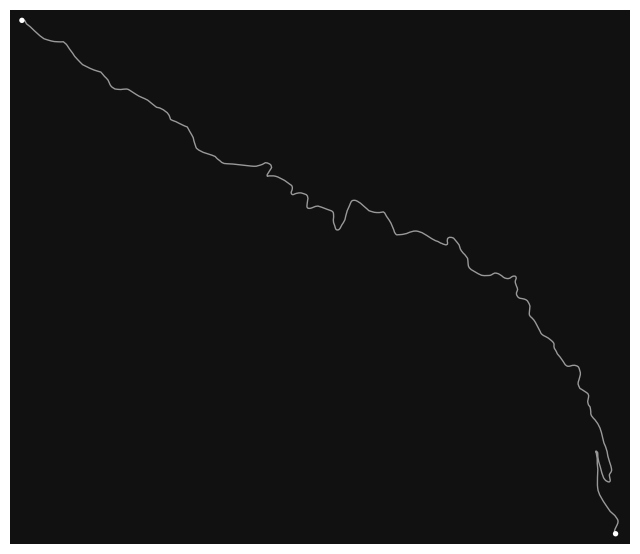

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [20]:
ox.plot_graph(nx.edge_subgraph(G_dir,map(tuple,path[:])))

0.008135080337524414 0.03561520576477051


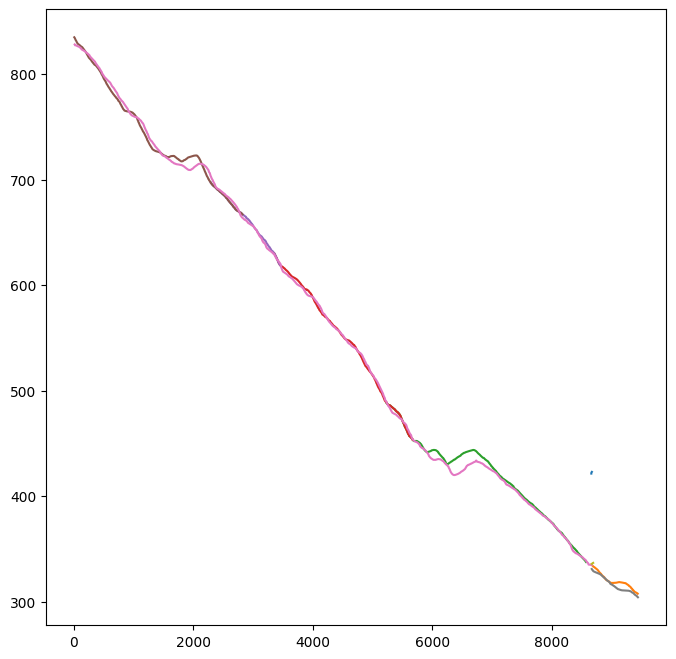

In [21]:
plt.rcParams['figure.figsize']=(8,8)
t1=time.time()
slopes=get_slopes(meta_segments,max_delta_T=900)
slopes=harmonize_slopes(slopes)
slopes=discard_outliers(slopes)
t2=time.time()
pairwise_shifts,affine_slopes=get_pairwise_shifts(slopes,overlay_thresh=0.25,)
t3=time.time()
print(t3-t2,t2-t1)
for slope in slopes:
    plt.plot(slope['X'],slope['Y'])
for k in affine_slopes:
    slope=slopes[k]
    #plt.plot(slope['X'],slope['Y'],c='k')    

0.00028443336486816406


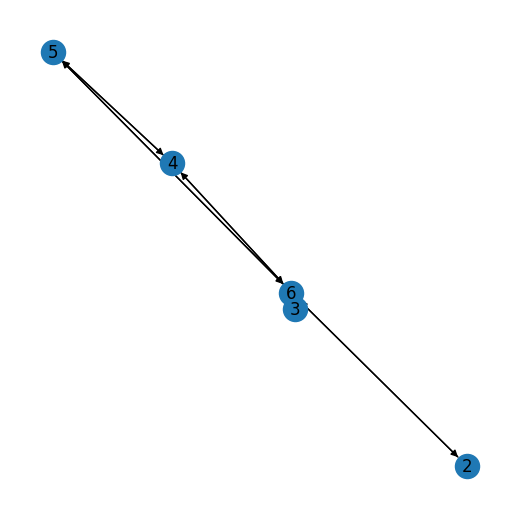

In [22]:
plt.rcParams['figure.figsize']=(5,5)

file_paths=list(np.unique(garmin_df['file_path']))
N=len(slopes)
pos={k:(np.mean(slopes[k]['X']),file_paths.index(slopes[k]['file_path'])) for k in range(N)} 
t1=time.time()
shift_G=get_shifts_graph(pairwise_shifts,len(slopes),corr_tresh=0.99)
t2=time.time()
print(t2-t1)

pos={k:(np.mean(slopes[k]['X']),file_paths.index(slopes[k]['file_path'])) for k in range(N)} 
pos={k:(np.mean(slopes[k]['X']),np.mean(slopes[k]['Y']))for k in range(N)} 
nx.draw(shift_G,pos=pos,with_labels=True)

0.0004947185516357422


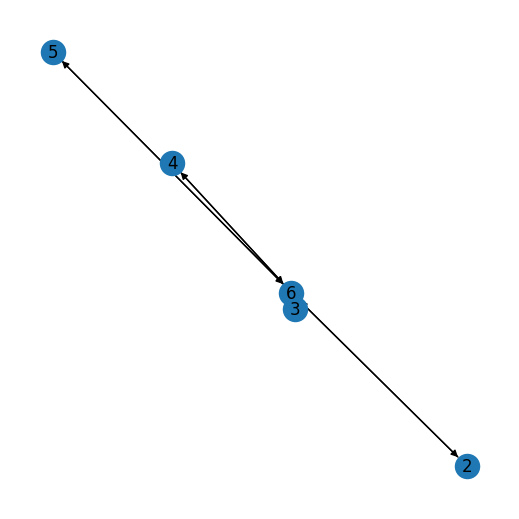

In [23]:
t1=time.time()
edges=list(nx.minimum_spanning_edges(nx.Graph(shift_G),weight='weight',data=False))
edges+=[(v,u) for u,v in edges]
shift_tree=nx.edge_subgraph(shift_G,edges)
t2=time.time()
print(t2-t1)
nx.draw(shift_tree,pos=pos,with_labels=True)

0.0007991790771484375


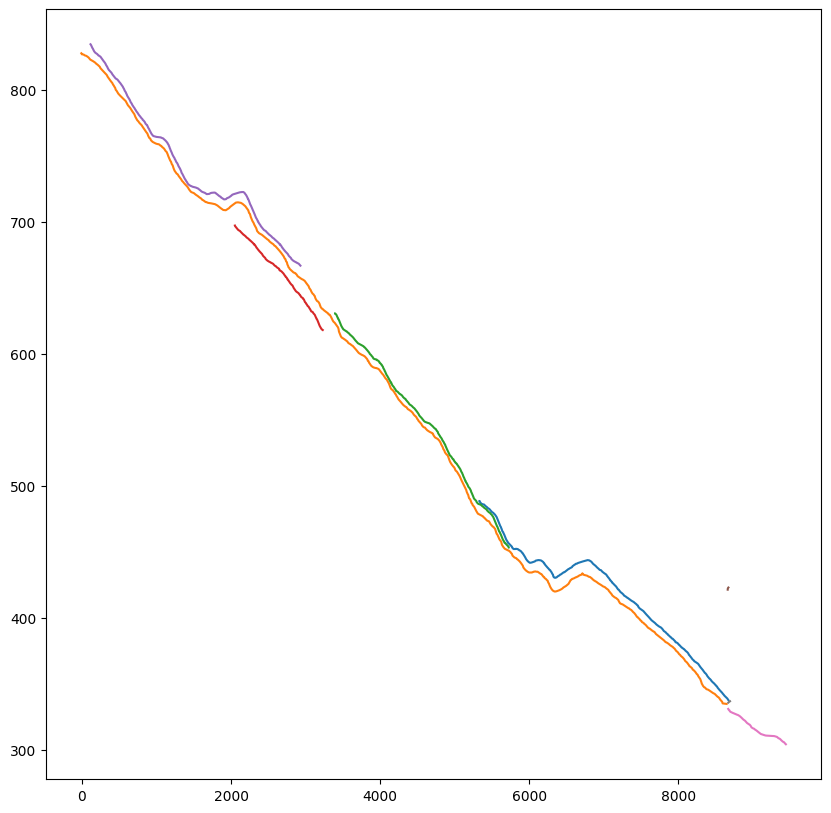

In [24]:
plt.rcParams['figure.figsize']=(10,10)
t1=time.time()
corrected_slopes,shifts=realign_slopes_from_tree(shift_tree,slopes,min_components=1)
corrected_slopes+=[slopes[k] for k in affine_slopes]
t2=time.time()
print(t2-t1)
for slope in corrected_slopes:
    plt.plot(slope['X'],slope['Y'])



In [25]:
cover,extremities=get_cover(corrected_slopes,min_count=2)

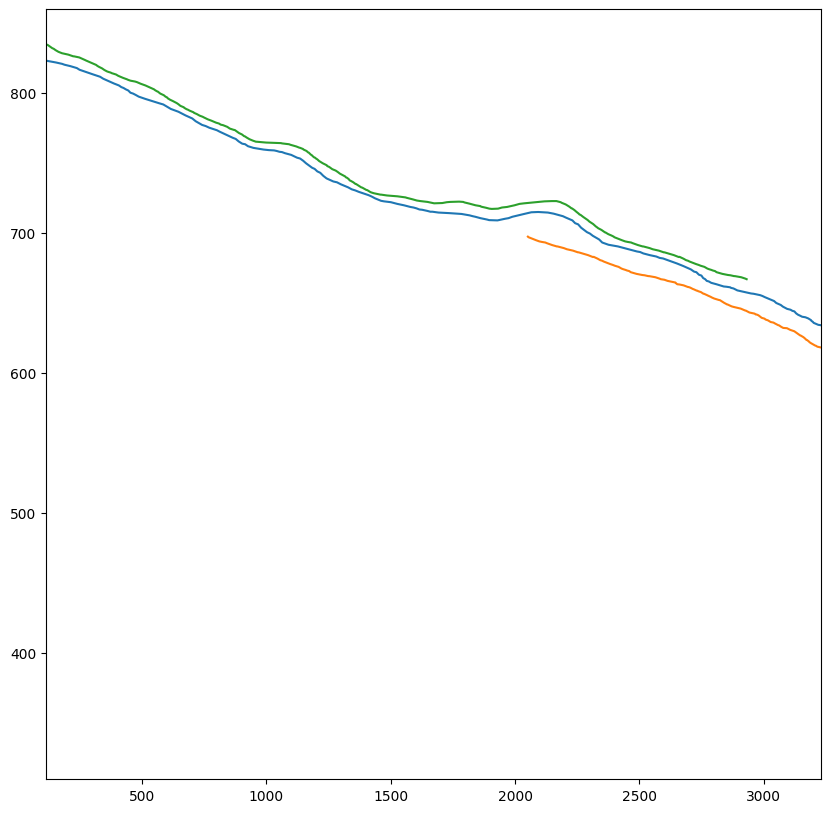

In [26]:
i=0
sub_slopes=[corrected_slopes[k] for k in cover[i]]
x_min,x_max=extremities[i]
plt.xlim(x_min,x_max)
for slope in sub_slopes:
    plt.plot(slope['X'],slope['Y'])    


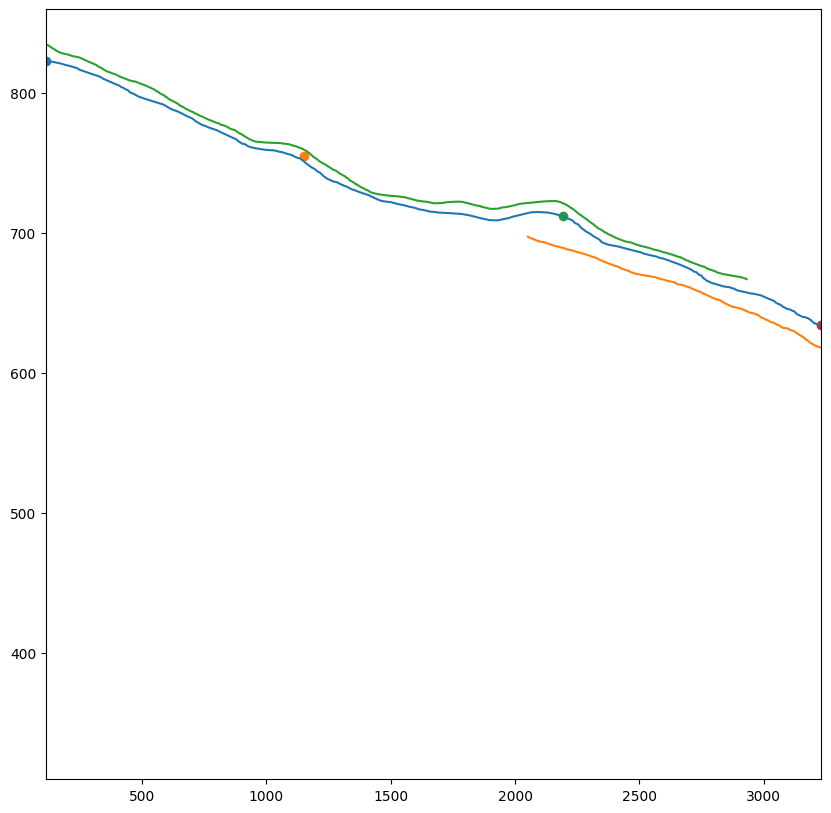

In [27]:
plt.xlim(x_min,x_max)
intermediate_distance=1000
intermediate_points=np.linspace(x_min,x_max,max(round((x_max-x_min)/intermediate_distance)+1,2))
for slope in sub_slopes:
    plt.plot(slope['X'],slope['Y']) 
intermediate_elevations=get_intermediate_elevation(intermediate_points,sub_slopes)
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))

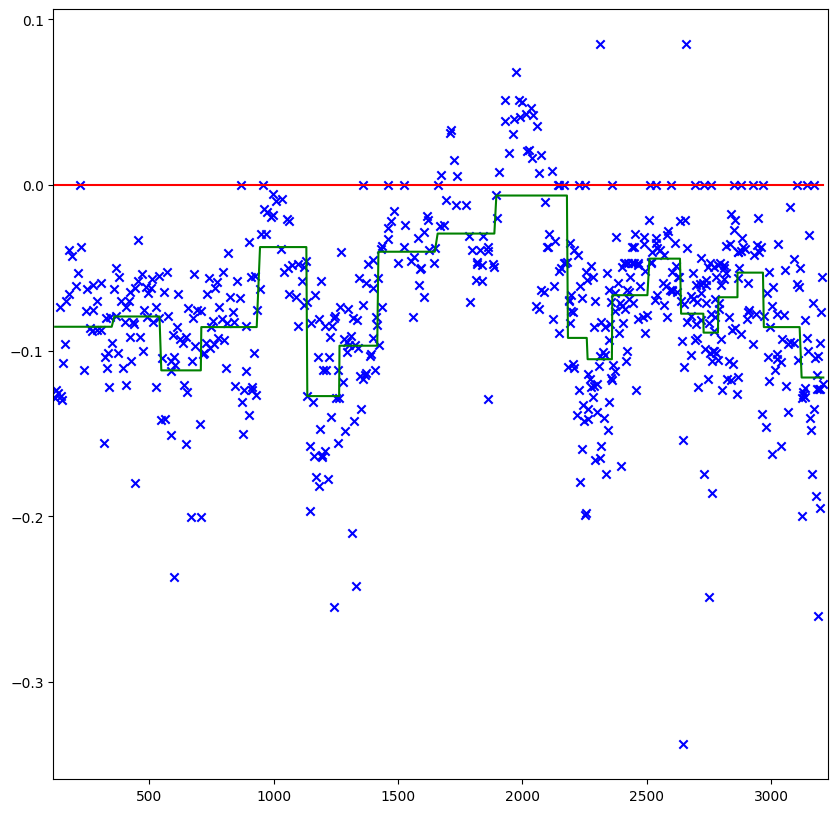

In [28]:
plt.xlim(x_min,x_max)
output=approximate_derivative(sub_slopes,x_min=x_min,x_max=x_max,
                                    min_samples_leaf=25,min_impurity_decrease=0.5*float('1e-6'))
if output is not None:
    X,dYdX,model=output
    Z=model.predict(X.reshape(-1,1))
    plt.scatter(X,dYdX,c='b',marker='x')
    plt.plot([0,X[-1]],[0,0],c='r')
    plt.plot(X,Z,c='g')


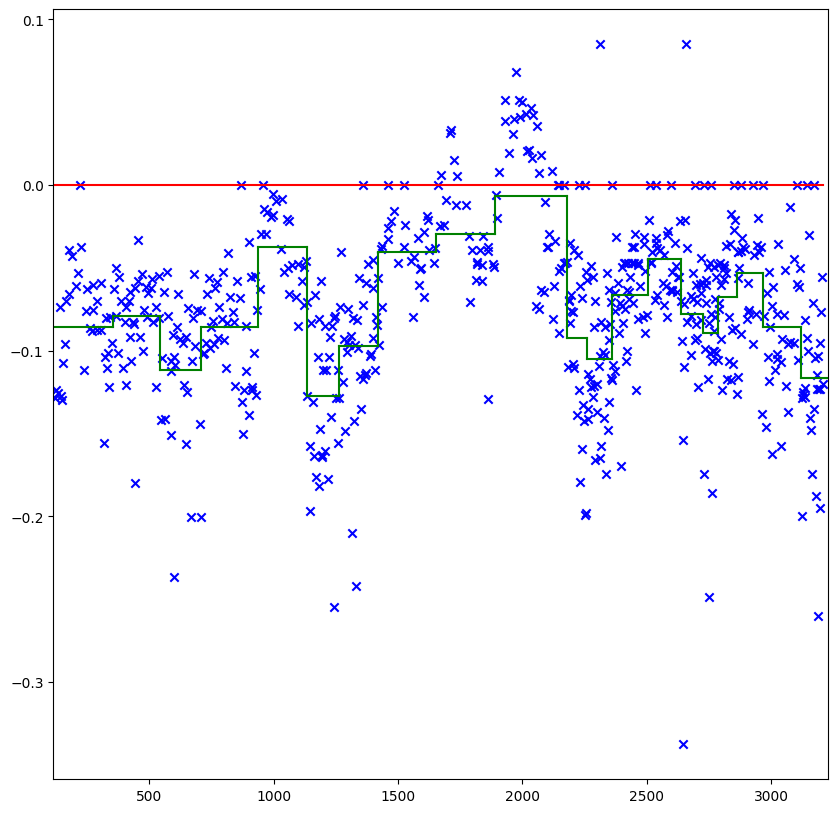

In [29]:
plt.xlim(x_min,x_max)
intervals=simplify_tree(model.tree_,x_min,x_max,min_interval=100.)
plt.scatter(X,dYdX,c='b',marker='x')
plt.plot([0,X[-1]],[0,0],c='r')
for x1,x2,v in intervals:
    plt.plot([x1,x2],[v,v],c='g')
for k in range(len(intervals)-1):
    _,x1,v1=intervals[k]
    x2,_,v2=intervals[k+1]
    plt.plot([x1,x2],[v1,v2],c='g')

-23.975443 m elevation difference on a 3.115474 kms long path


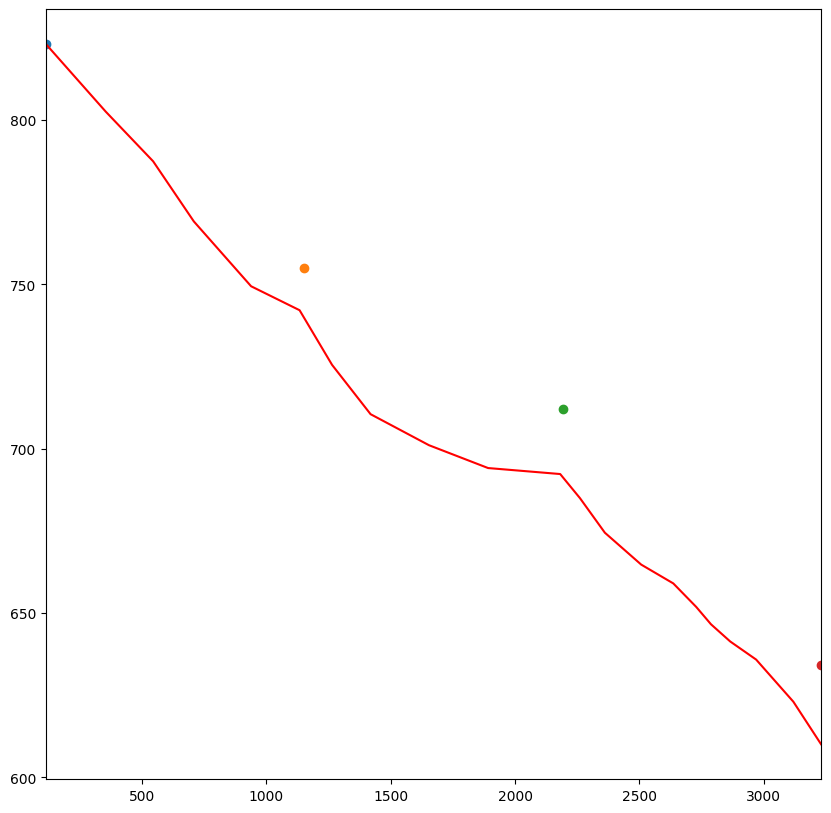

In [30]:
plt.xlim(x_min,x_max)
XX,YY=infer_curve_from_estimated_gradient(intervals,np.nanmedian(intermediate_elevations[0]))

plt.plot(XX,YY,c='r')
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))
print('%f m elevation difference on a %f kms long path'%(YY[-1]-np.nanmedian(intermediate_elevations[-1]),(x_max-x_min)/1000))

total error 23.975443:


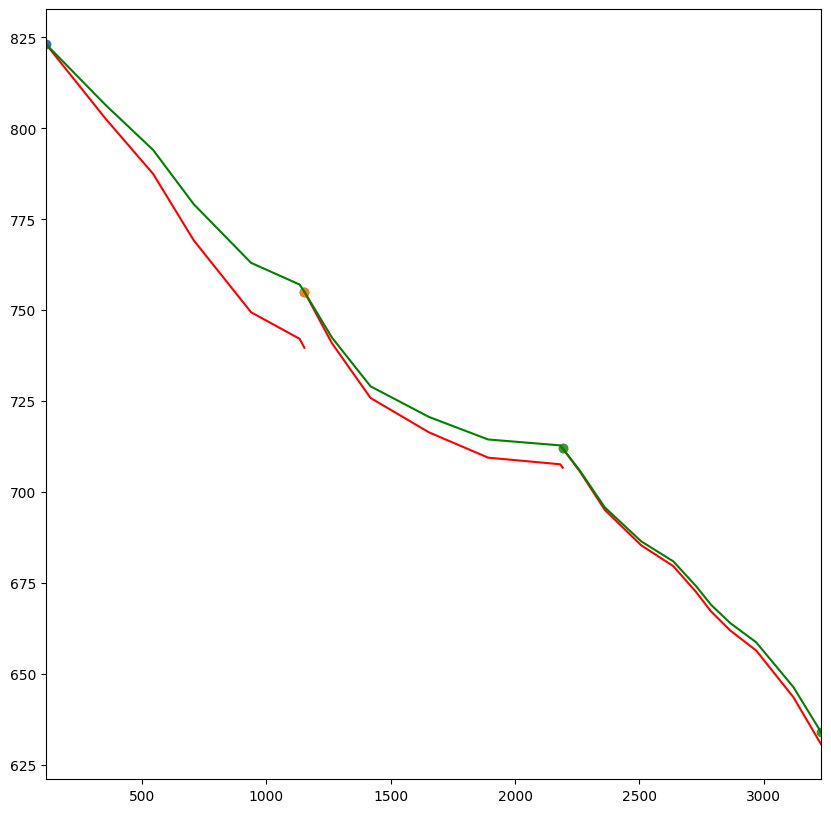

In [32]:
plt.xlim(x_min,x_max)
s=0
for k in range(len(intermediate_points)-1):
    sub_intervals=[[min(max(x1,intermediate_points[k]),intermediate_points[k+1]),min(max(x2,intermediate_points[k]),intermediate_points[k+1]),v] for x1,x2,v in intervals if x2>=intermediate_points[k] and x1<=intermediate_points[k+1]]
    XX,YY=infer_curve_from_estimated_gradient(sub_intervals,np.nanmedian(intermediate_elevations[k]))
    plt.plot(XX,YY,c='r')
    delta_expected=np.nanmedian(intermediate_elevations[k+1])-np.nanmedian(intermediate_elevations[k])
    YY,delta=adjust_curve_elevation(YY,delta_expected)
    s+=abs(delta-delta_expected)
    plt.plot(XX,YY,c='g')

    
    plt.scatter([intermediate_points[k],intermediate_points[k+1]],[np.nanmedian(intermediate_elevations[k]),np.nanmedian(intermediate_elevations[k+1])])
print('total error %f:'%s)

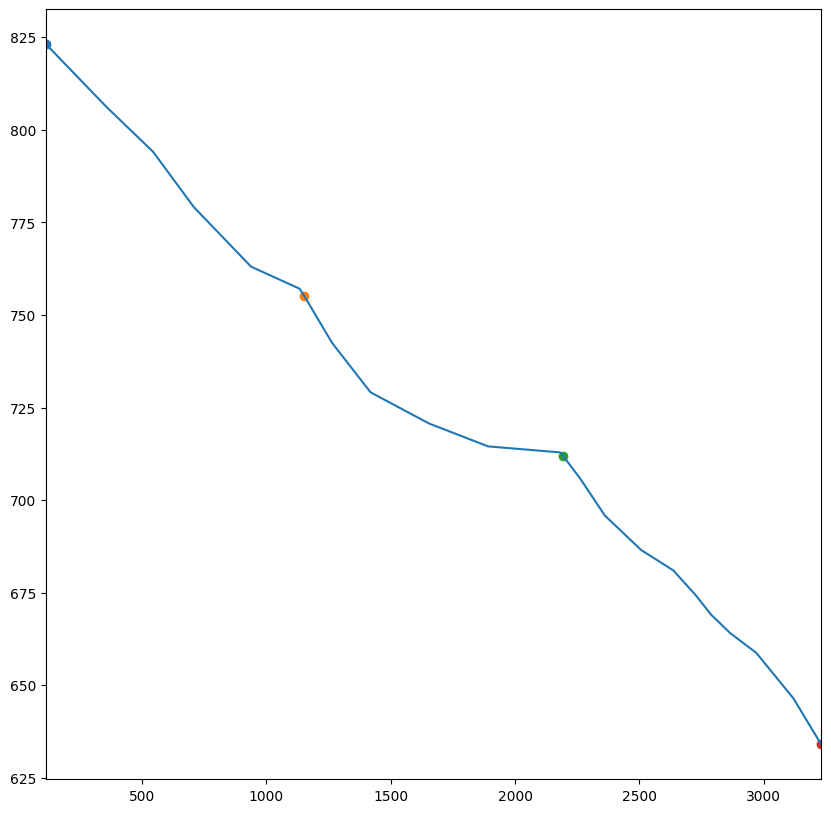

In [33]:
plt.xlim(x_min,x_max)
X,Y=approximate_slope(sub_slopes,x_min,x_max,intermediate_distance=1000)
X,Y=np.array(X),np.array(Y)
plt.plot(X,Y)
for k,l in enumerate(intermediate_elevations):
    plt.scatter(intermediate_points[k],np.nanmedian(l))
    
